In [ ]:
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent))

# Import modules from the custom library
from src import Tensor, ModuleOutput
from src.core.utils import context_manager
from src.architectures.sequential import Sequential
from src.architectures.auto_encoder import ConditionalVAE
from src.core.utils.data_processing import one_hot_encoding

### Constants

In [2]:
# Define the path to the model checkpoint
model_path = Path().resolve() / 'checkpoints' / 'conditional_variational_autoencoder'

### Load the model

In [3]:
# Load the trained model
conditional_vae: Sequential = Sequential.load(str(model_path))

# Set the model to evaluation mode
conditional_vae.eval()

In [ ]:
# Access the CVAE core module
cvae: ConditionalVAE = conditional_vae.modules[0]

# Read generation dimensions directly from the loaded model
latent_dim = cvae.encoder.latent_dim
num_classes = cvae.encoder.num_classes

# Print the generation dimensions
print('Latent dim:', latent_dim)
print('Num classes:', num_classes)

Latent dim: 32
Num classes: 10


### Generation

In [9]:
# Define how many samples to generate per class
samples_per_class = 5

# Build labels: 0..num_classes-1 repeated
labels = np.repeat(np.arange(num_classes), samples_per_class)
labels_tensor = Tensor(labels, dtype=np.int8)
labels_one_hot = one_hot_encoding(labels_tensor, n_classes=num_classes, dtype=np.float32)

# Sample latent vectors from the prior z ~ N(0, I)
z = Tensor(np.random.randn(len(labels), latent_dim), dtype=np.float32)

# Set the context manager to no_grad to disable gradient tracking during inference
with context_manager.no_grad():
    # Generate images using the decoder conditioned on labels
    generated: ModuleOutput = cvae.decoder(x=z, y=labels_one_hot)

# Extract the generated images from the ModuleOutput
generated_images: Tensor = generated.output

### Display generated images

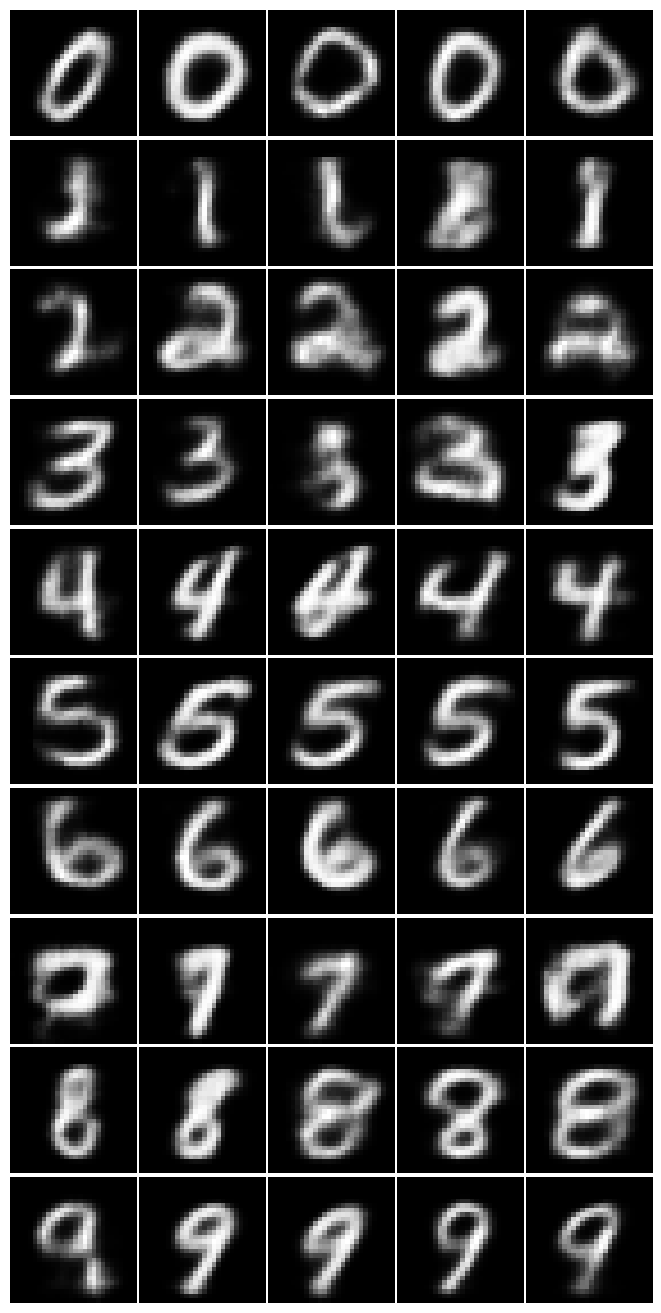

In [10]:
# Plot generated images grouped by class label
fig, axes = plt.subplots(
    num_classes,
    samples_per_class,
    figsize = (1.3 * samples_per_class, 1.3 * num_classes)
)

# Ensure axes is always 2D
if num_classes == 1:
    axes = np.expand_dims(axes, axis=0)
if samples_per_class == 1:
    axes = np.expand_dims(axes, axis=1)

# Convert generated images to numpy for plotting
images_np = generated_images.to_numpy()

# Plot each generated image in the corresponding subplot
for cls in range(num_classes):
    for j in range(samples_per_class):
        idx = cls * samples_per_class + j
        ax = axes[cls, j]
        ax.imshow(images_np[idx], cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_ylabel(f'Label {cls}', fontsize=9)

# Adjust layout and display the plot
plt.tight_layout(pad=0.25)
plt.show()